<a href="https://colab.research.google.com/github/jsansao/dlvc/blob/main/Licao6_CatOrDog_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Usando imagens mais sofisticadas com CNN 

Na lição anterior, usamos CNN para aumentar a eficiência das redes neurais no reconhecimento de peças de vestimentas. 

Nessa lição, aumentaremos a dificuldade da classifição, fazendo o reconhencimento de imagens reais de gatos e cães. 

O dataset utilizados anteriormente eram monocromáticas, de mesmas dimensões e formato. Imagens "reais" são coloridas, vêm em diferentes tamanhos e aspectos. 

Uma parte importante é processamento dos dados (no caso imagens) para utilização dos métodos de aprendizado. 

Os passos seguintes são:

1. Explorar exemplos de dados do banco de imagens de "Gatos e Cães"
2. Construir e treinar uma rede neural convolucional que discrimine entre gato e cão. 
3. Avaliar as acurácias de treinamento e validação



## Exploração do banco de imagens

Vamos iniciar o trabalho 
fazendo o download de um arquivo zipado contendo 2000 arquivos jpg de gatos e cães, extraindo localmente em `/tmp`.

**Obs:** O conjunto de imagens foi extraído de ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data), disponível no Kaggle. O conjunto original tem 25000 imagens. Este é apenas um subconjunto. 



In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2021-10-04 23:13:17--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.128, 64.233.191.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  37.0MB/s    in 1.8s    

2021-10-04 23:13:19 (37.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



O código seguinte usa a biblioteca OS para usar funções do sistema operacional (Linux, no caso), dando acesso ao sistema de arquivos e a biblioteca zipfile permitindo descompactar os dados. 

In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

O conteúdo do arquivo zip é extraído para `/tmp/cats_and_dogs_filtered`, contendo os sub-diretórios `train` e `validation`, para treinamento e validação respectivamente. Cada um desses sub-diretórios também é sub-dividido em `cats` e `dogs`. 

As imagens não explicitamente rotuladas como cães e gatos. Vamos usar a estrutura dos diretórios com uma função chamada `ImageGenerator` para efetuar a rotulação e codificação das imagens. 

Definindo cada um dos diretórios:



In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')




Vamos inspecionar como estão armazenadas as imagens de `cats` e `dogs` no diretório `train`: 

In [ ]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.496.jpg', 'cat.560.jpg', 'cat.304.jpg', 'cat.613.jpg', 'cat.504.jpg', 'cat.759.jpg', 'cat.448.jpg', 'cat.183.jpg', 'cat.208.jpg', 'cat.0.jpg']
['dog.912.jpg', 'dog.524.jpg', 'dog.735.jpg', 'dog.961.jpg', 'dog.525.jpg', 'dog.852.jpg', 'dog.479.jpg', 'dog.10.jpg', 'dog.208.jpg', 'dog.532.jpg']



Determinando o número de imagens em cada sub-diretório (de `train` e `validation`):

In [ ]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


Temos 1000 imagens de treinamento para cães e gatos, e 500 imagens de validação (para cada classe). 

Com a matplotlib, vamos visualizar algumas das imagens. 

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

Vamos mostrar um lote com 8 gatos e 8 cães. O lote altera as imagens cada vez que se roda essa célula. 

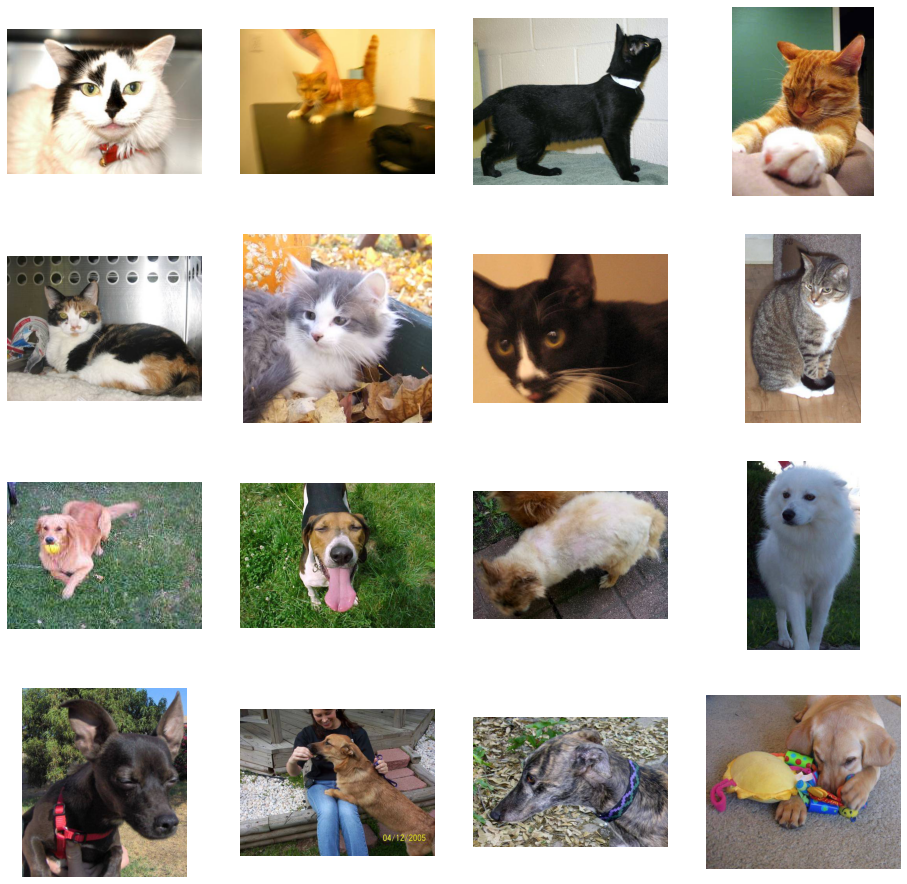

In [19]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Construindo um pequeno modelo para atingir acurácia de  ~72% 

Como as imagens vistas anteriormente tem tamanhos e aspectos diferentes, antes de treinarmos a rede neural, devemos executar um padronização em um tamanho uniforme. 

Transformaremos as imagens em 150x150, através de um pré-processamento. 

Vamos definir o modelo:


In [ ]:
import tensorflow as tf

Vamos definir o modelo `Sequential` como anteriormente, adicionando as camadas convolucionais inicialmente. Observe o parâmetro de formato de entrada (`input_shape`). No exemplo anterior, as imagens era 28x28x1 (28x28 em tons de cinza). Agora, o formato é 150x150x3 (150x150 com 3 canais de cores). 


Adicionaremos um par de camadas convolucionais, executar o "achatamento" e alimentar às camadas densamente conectadas. 

Finalmente adicionamos as camadas densamente conectadas, a camada oculta e a camada de saída. 

A camada de saída apresenta apenas um neurônio por se tratar de um problema de classificação binário, sendo a saída um escalar de 0 a 1, passando por uma função de ativação sigmoidal. 


In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

O método `model.summary()` exibe um resumo da estrutura. 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

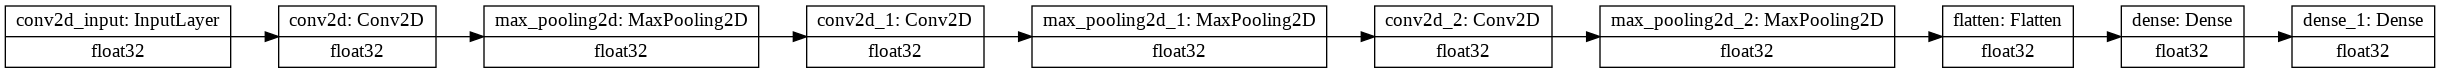

In [ ]:
model.summary()
tf.keras.utils.plot_model(model, rankdir='LR',show_dtype=True)

A coluna "output shape" column shows how the size of your feature map evolves in each successive layer. 

A coluna `output shape` mostra como o tamanho dos "mapas" evolui ao longo de cada camada. 

As camadas de convolução reduzem o tamanho devido à filtragem das convoluções e cada camada de "pooling" diminui as dimensões pela metade.


Agora vamos configurar as especificações do modelo de treinamento. A função de perda indicada é `binary_crossentropy`, pois trata-se de um problema de classificação binário e a função de ativação final é sigmoidal. 

Utilizaremos o otimizador `rmsprop` com taxa de aprendizado de `0.001, monitorando a acurácia durante o treinamento. 


**OBS**: Neste caso, usar o [RMSprop](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) é mais indicado do que [gradiente descendente estocástico](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), pois RMSprop automatizado o ajuste da taxa de aprendizado. (Outros otimizadores, como [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) e [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), também tem a propriedade de adaptar a taxa de aprendizado e funcionariam igualmente aqui.)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])


### Pré-processamento de dados

Vamos configurar os geradores de dados que acessarão as imagens nas pastas de origem, converter para tensores `float32` e serão usado para alimentar as redes com os respectivos rótulos. 

Usaremos um gerador para as imagens de treinamento e outro para validação. Os geradores liberaram lotes com 20 imagens de tamanho 150x150 e rótulos.

Novamente, as imagens devem ser normalizadas na faixa de `[0,1]`, que pode ser feito através do parâmetro `rescale` da  classe `keras.preprocessing.image.ImageDataGenerator`

Os "flows" podem ser gerados com os métodos flow ou flow_from_directory.



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Treinamento

Treinaremos a rede com as 2000 imagens de treinamento por 15 épocas e validaremos com as 1000 imagens de teste. 




In [ ]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2)

Epoch 1/15
100/100 - 59s - loss: 0.7088 - accuracy: 0.5740 - val_loss: 0.6326 - val_accuracy: 0.6430
Epoch 2/15
100/100 - 57s - loss: 0.6143 - accuracy: 0.6680 - val_loss: 0.5857 - val_accuracy: 0.6700
Epoch 3/15
100/100 - 57s - loss: 0.5213 - accuracy: 0.7430 - val_loss: 0.5828 - val_accuracy: 0.7040
Epoch 4/15
100/100 - 57s - loss: 0.4449 - accuracy: 0.7910 - val_loss: 0.5503 - val_accuracy: 0.7190
Epoch 5/15
100/100 - 58s - loss: 0.3636 - accuracy: 0.8425 - val_loss: 0.5722 - val_accuracy: 0.7210
Epoch 6/15
100/100 - 58s - loss: 0.2664 - accuracy: 0.8925 - val_loss: 0.7730 - val_accuracy: 0.7060
Epoch 7/15
100/100 - 57s - loss: 0.1989 - accuracy: 0.9230 - val_loss: 0.7787 - val_accuracy: 0.7290


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7faf8de6c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 8/15
100/100 - 57s - loss: 0.1325 - accuracy: 0.9525 - val_loss: 0.8935 - val_accuracy: 0.7350
Epoch 9/15
100/100 - 57s - loss: 0.1097 - accuracy: 0.9565 - val_loss: 0.8884 - val_accuracy: 0.7080
Epoch 10/15
100/100 - 57s - loss: 0.0629 - accuracy: 0.9835 - val_loss: 1.2614 - val_accuracy: 0.7190
Epoch 11/15
100/100 - 57s - loss: 0.0427 - accuracy: 0.9860 - val_loss: 1.4941 - val_accuracy: 0.7270
Epoch 12/15
100/100 - 58s - loss: 0.0931 - accuracy: 0.9780 - val_loss: 1.5170 - val_accuracy: 0.7240
Epoch 13/15
100/100 - 57s - loss: 0.1142 - accuracy: 0.9755 - val_loss: 1.6191 - val_accuracy: 0.7160
Epoch 14/15
100/100 - 58s - loss: 0.0443 - accuracy: 0.9885 - val_loss: 1.6433 - val_accuracy: 0.7320
Epoch 15/15
100/100 - 57s - loss: 0.0535 - accuracy: 0.9910 - val_loss: 1.7110 - val_accuracy: 0.7310


###Rodando o modelo de predição

Com o código seguinte, será possível testar a rede treinada com um arquivo envio do seu computador. 


In [21]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
    
  else:
    print(fn + " is a cat")
 

Saving cat.2040.jpg to cat.2040.jpg
Saving cat.2041.jpg to cat.2041.jpg
Saving cat.2042.jpg to cat.2042.jpg
Saving cat.2043.jpg to cat.2043.jpg
Saving cat.2044.jpg to cat.2044.jpg
Saving cat.2045.jpg to cat.2045.jpg
Saving cat.2046.jpg to cat.2046.jpg
Saving cat.2047.jpg to cat.2047.jpg
Saving cat.2048.jpg to cat.2048.jpg
Saving cat.2049.jpg to cat.2049.jpg
Saving cat.2050.jpg to cat.2050.jpg
Saving cat.2051.jpg to cat.2051.jpg
Saving cat.2052.jpg to cat.2052.jpg
Saving cat.2053.jpg to cat.2053.jpg
Saving cat.2054.jpg to cat.2054.jpg
Saving cat.2055.jpg to cat.2055.jpg
Saving cat.2056.jpg to cat.2056.jpg
Saving cat.2057.jpg to cat.2057.jpg
Saving cat.2058.jpg to cat.2058.jpg
Saving cat.2059.jpg to cat.2059.jpg
Saving cat.2060.jpg to cat.2060.jpg
[0.]
cat.2040.jpg is a cat
[1.]
cat.2041.jpg is a dog
[1.]
cat.2042.jpg is a dog
[0.]
cat.2043.jpg is a cat
[1.]
cat.2044.jpg is a dog
[0.]
cat.2045.jpg is a cat
[0.]
cat.2046.jpg is a cat
[0.]
cat.2047.jpg is a cat
[1.]
cat.2048.jpg is a dog
[

### Visualização de representações intermediárias

Para se ter uma noção das características que nossa rede convolucional aprendeu, uma atividade interessante é visualizar como uma entrada é transformada enquanto percorre a rede. 

Tomaremos uma imagem aleatório do conjunto de treinamento e veremos em cada linha, a saída de uma camada, e cada imagem na linha é o resultado de um filtro específico. Rode novamente para ver as representações de diferentes imagens. 


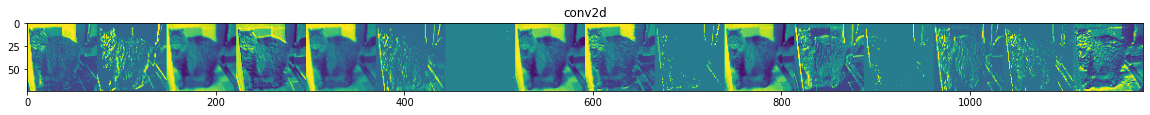

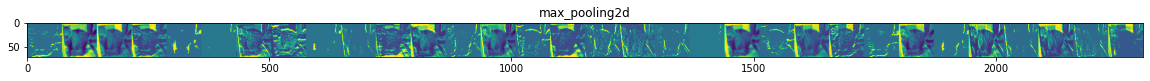

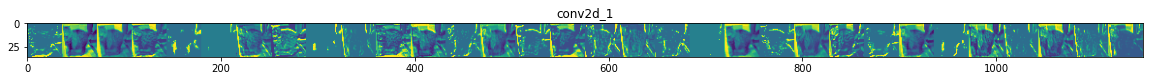

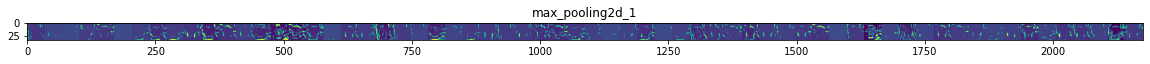

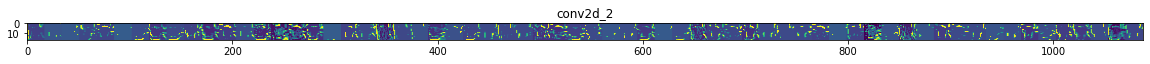

In [22]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 


É possível ver que nas primeiras camadas, a representação está próxima da imagem de entrada. As camadas seguintes são cada vez mais compactas e abstratas. A camadas começam a destacar as características que a rede fica mais atenta e mostram cada vez menos características "ativadas". Esse efeito é chamado esparsidade, fato crucial no deep learning. 

As representações deixam de ser derivações da imagem original, refinando a informação sobre a determinada classe da imagem. 



### Avaliando acurácia e perda do modelo


Text(0.5, 1.0, 'Training and validation loss')

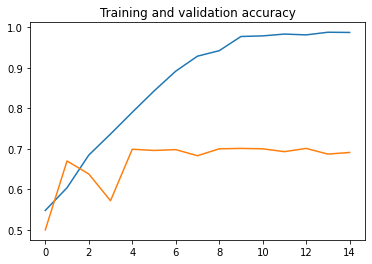

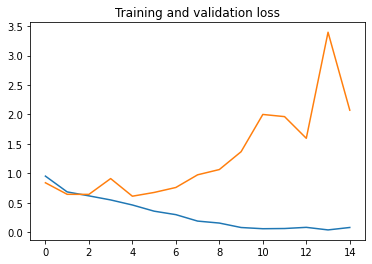

In [24]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

É possível notar que a rede treinada está em overfitting. A acurácia de validação é muito inferior à de treinamento. 

Isso decorre do excesso de parâmetros em relação ao dados de treinamento, particularizando em excesso o modelo. 

Na próxima lição, veremos formas de evitar o overfitting.